In [24]:
import os
from math import pi
from time import time


os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c


from ott.tools.unreg import wassdis_p


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, NFW_POTENTIAL, PlummerParams, MN_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity
from odisseo.utils import E_tot, Angular_momentum
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Plummer Sphere

In [25]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [26]:
# Define the 
config = SimulationConfig(N_particles=1_000, 
                          return_snapshots=False, 
                          num_snapshots=100, 
                          num_timesteps=50, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme=DIRECT_ACC_MATRIX,
                          batch_size=50, 
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (2* u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=False, num_snapshots=100, fixed_timestep=True, num_timesteps=50, softening=np.float64(0.010000000000000002), integrator=0, acceleration_scheme=2, batch_size=50, double_map=False, external_accelerations=(0,))
SimulationParams(G=1, t_end=np.float64(1.3414174818406912), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(1.0)), NFW_params=NFWParams(Mvir=np.float64(10000.0), r_s=np.float64(2.0), c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28))


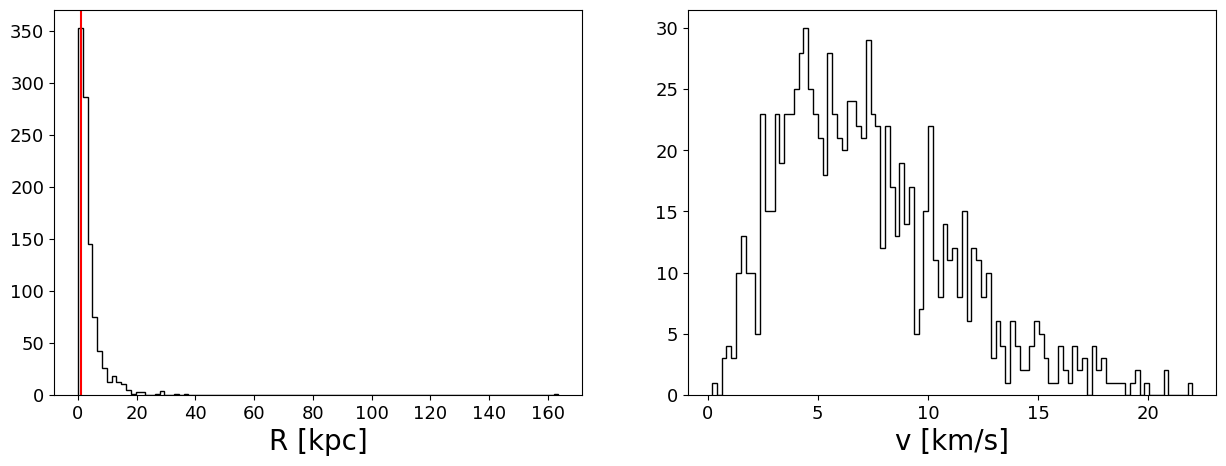

In [27]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [28]:
# radial distance of the center of mass
rp=20*u.kpc.to(code_units.code_length)

#sampling the center of mass on the sphere
key = random.PRNGKey(42)
num_samples = 1  # Number of positions to generate
pos = sample_position_on_sphere(key, rp, num_samples)
vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
state_com = construct_initial_state(pos, vel)

# Calculate the acceleration at the center of mass
acc_com, _ = NFW(state_com, config, params, return_potential=True)
#circular velocity at the center of mass
v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
inclination = jnp.radians(30)  # 30-degree inclination
#bulk motion to give to each particle of the Plummer sphere
vel = inclined_circular_velocity(pos, v_c, inclination)


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos
velocities = velocities + vel
initial_state = construct_initial_state(positions, velocities)

#evolve 
target_state = time_integration(initial_state, mass, config, params)
energy_target, Lz_target = E_tot(target_state, mass, config, params), Angular_momentum(target_state, mass, )[2]
distribution_r_target = jnp.linalg.norm(target_state[:, 0], axis=1)
hist_target, _ = jnp.histogram(distribution_r_target, bins=100, range=(0, (25*u.kpc).to(code_units.code_length).value))


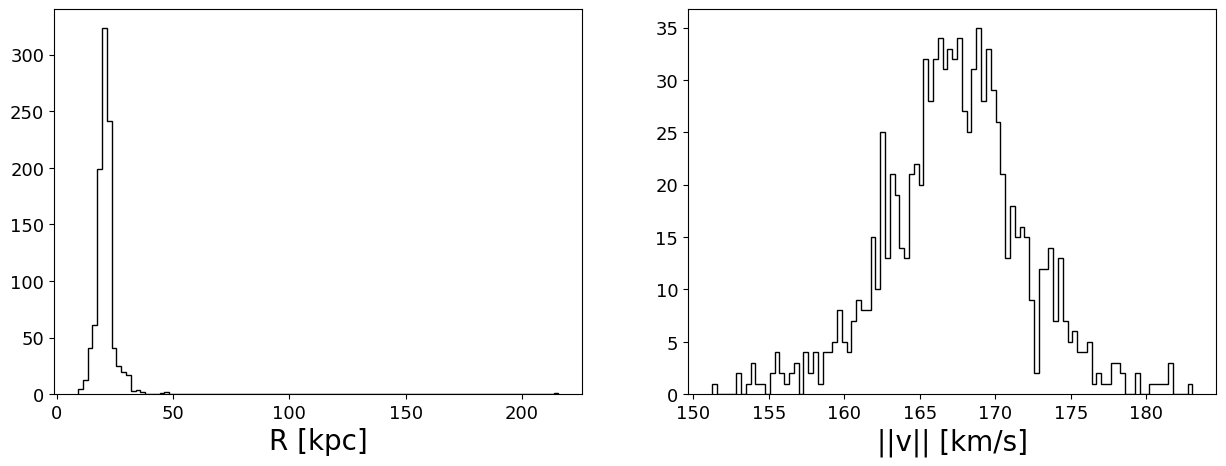

In [29]:
#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((distribution_r_target * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('||v|| [km/s]')
plt.show()


Text(0.5, 0.92, 'Target state')

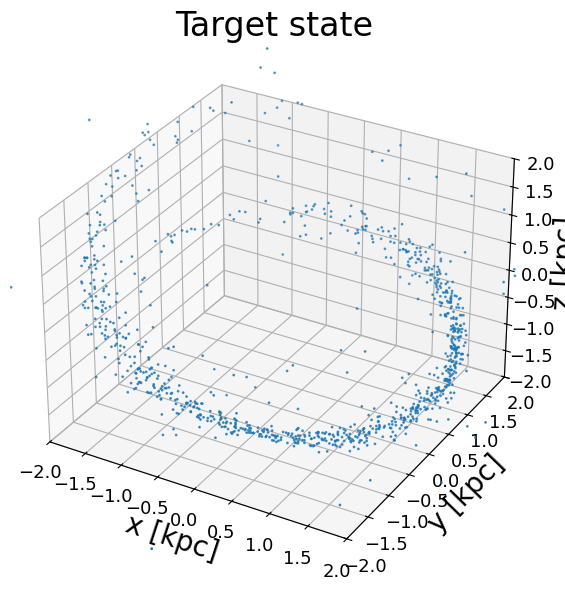

In [30]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(target_state[:, 0, 0], target_state[:, 0, 1], target_state[:, 0, 2], s=1)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_zlabel('z [kpc]')
ax.set_xlim(-rp, rp)
ax.set_ylim(-rp, rp)
ax.set_zlim(-rp, rp)
ax.set_title('Target state')

In [47]:
def js_divergence(hist1, hist2, epsilon=1e-8):
    hist1 = jnp.clip(hist1, epsilon, 1.0)
    hist2 = jnp.clip(hist2, epsilon, 1.0)
    m = 0.5 * (hist1 + hist2)
    return 0.5 * jnp.sum(hist1 * jnp.log(hist1 / m)) + 0.5 * jnp.sum(hist2 * jnp.log(hist2 / m))

def chi_squared_distance(hist1, hist2, epsilon=1e-8):
    return jnp.sum((hist1 - hist2)**2 / (hist1 + hist2 + epsilon))

def wasserstein_distance(hist1, hist2, ):
    return wassdis_p(hist1, hist2, p=0.01)
    

def time_integration_for_mass_grad(Mvir, ):
    params = SimulationParams(t_end = (5*u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=Mvir,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                          G=G, ) 
    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(int(time())), params=params, config=config)
    pos = sample_position_on_sphere(key, rp, num_samples)
    vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
    state_com = construct_initial_state(pos, vel)

    # Calculate the acceleration at the center of mass
    acc_com, _ = NFW(state_com, config, params, return_potential=True)
    #circular velocity at the center of mass
    v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
    inclination = jnp.radians(30)  # 30-degree inclination
    #bulk motion to give to each particle of the Plummer sphere
    vel = inclined_circular_velocity(pos, v_c, inclination)
    # Add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos
    velocities = velocities + vel
    initial_state = construct_initial_state(positions, velocities)
    
    #integrate in time
    final_state = time_integration(initial_state, mass, config, params)
    distribution_r = jnp.linalg.norm(final_state[:, 0], axis=1)
    hist, _ = jnp.histogram(distribution_r, bins=100, range=(0, (25*u.kpc).to(code_units.code_length).value))
    

    # Calculate the loss
    energy, Lz = E_tot(final_state, mass, config, params), Angular_momentum(final_state, mass,)[2]
    # loss = ((Lz - Lz_target)/Lz_target)**2 
    # loss = ((energy- energy_target)/energy_target)**2
    loss = ((Lz - Lz_target)/Lz_target)**2  + ((energy - energy_target)/energy_target)**2
    # loss = js_divergence(hist, hist_target) 
    # loss = chi_squared_distance(hist, hist_target)
    # loss = wasserstein_distance(hist[None, :], hist_target[None, :])
    
    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (1e11 * u.Msun).to(code_units.code_mass).value
loss, grad = jax.value_and_grad(time_integration_for_mass_grad)(Mvir, )
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 -0.005824124766327602
Loss:
 1.2725409060454633


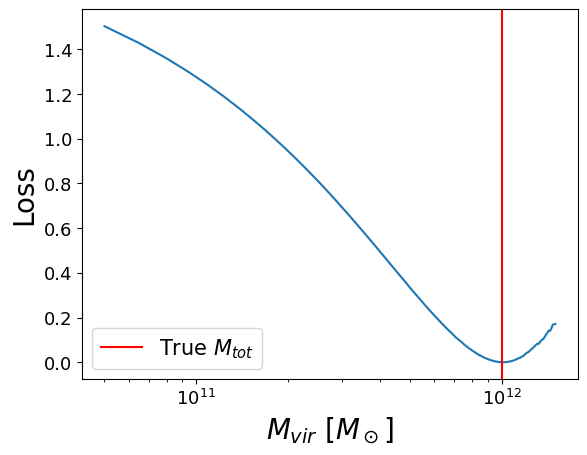

In [48]:
Mvir =  (jnp.linspace(0.5*1e11, 1.5*1e12, 100) * u.Msun).to(code_units.code_mass).value
loss = vmap(time_integration_for_mass_grad)(Mvir)

plt.figure()
plt.plot((Mvir*code_units.code_mass).to(u.Msun), loss)
plt.axvline((1e12 * u.Msun).value, color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
